## Data Loading & Variable Creation

In [266]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
                           roc_auc_score, balanced_accuracy_score)
import seaborn as sns
import matplotlib.pyplot as plt

In [268]:
# Load the cleaned dataset
df = pd.read_csv('/Users/jakubriha/Desktop/ECO482/Project/Data/dataset.csv')

In [274]:
# Create Lags

exclude_cols = ['Date', 'SNP500_Open', 'SNP500_Close', 'Target','returns_tomorrow']  

lags = [1, 3]

for col in df.columns:
    if col not in exclude_cols:
        for lag in lags:
            df[f'{col}_lag{lag}'] = df[col].shift(lag)

df = df.dropna().reset_index(drop=True)

In [276]:
# Create a second dataframe for scaled variables

from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['Target', 'Date', 'SNP500_Open', 'SNP500_Close', 'SNP500_Returns', 'returns_tomorrow'])
y = df['Target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
df_scaled['SNP500_Returns'] = df['SNP500_Returns']
df_scaled['SNP500_Returns_lag1'] = df['SNP500_Returns_lag1']
df_scaled['SNP500_Returns_lag3'] = df['SNP500_Returns_lag3']
df_scaled['returns_tomorrow'] = df['returns_tomorrow']
df_scaled['Target'] = df['Target']

In [278]:
# Create feature sets
financial_features = [
    'SNP500_Returns', 'VIX_Open','MA_20', 'MA_50', 'RSI', 'MACD_Hist', 'volatility_atr', 
    'momentum_stoch_rsi', 'volume_obv', 'trend_ichimoku_base', 'trend_macd']
financial_features_lags = [f'{feature}_lag{lag}' for feature in financial_features for lag in lags]

vader_news = ['nyt_vader_sentiment', 'wsj_vader_sentiment', 'wp_vader_sentiment']
vader_news_lags = [f'{feature}_lag{lag}' for feature in vader_news for lag in lags]

swn_news = ['nyt_swn_compound','wsj_swn_compound', 'wp_swn_compound']
swn_news_lags = [f'{feature}_lag{lag}' for feature in swn_news for lag in lags]

vader_trump = ['Trump_vader_sentiment']
vader_trump_lags = [f'Trump_vader_sentiment_lag{lag}' for lag in lags]

trump_themes = [
    col for col in df.columns 
    if col.startswith('Trump_') 
    and not col.startswith('Trump_vader_sentiment') 
    and not any(col.endswith(f'_lag{lag}') for lag in lags)]
trump_themes_lags = [f'{feature}_lag{lag}' for feature in trump_themes for lag in lags]

feature_sets = {
    'financial': financial_features,
    'financial_lags': financial_features + financial_features_lags,
    
    'vadernews': vader_news,
    'vadernews_lags': vader_news + vader_news_lags,
    
    'swnnews': swn_news,
    'swnnews_lags': swn_news + swn_news_lags,
    
    'vadertrump': vader_trump,
    'vadertrump_lags': vader_trump + vader_trump_lags,
    'trumpthemes': trump_themes,
    'trumpthemes_lags': trump_themes + trump_themes_lags,
    'trump_all': vader_trump + vader_trump_lags + trump_themes + trump_themes_lags,
    
    'financial_vadernews': financial_features + vader_news,
    'financial_vadernews_lags': financial_features + financial_features_lags + vader_news + vader_news_lags,
    'financial_swnnews': financial_features + swn_news,
    'financial_swnnews_lags': financial_features + financial_features_lags + swn_news + swn_news_lags,
    'financial_vadertrump': financial_features + vader_trump,
    'financial_vadertrump_lags': financial_features + financial_features_lags + vader_trump + vader_trump_lags,
    'financial_trumpthemes': financial_features + trump_themes,
    'financial_trumpthemes_lags': financial_features + financial_features_lags + trump_themes + trump_themes_lags,

    'financial_trump_all': financial_features + financial_features_lags + vader_trump + vader_trump_lags + trump_themes + trump_themes_lags,
    'financial_trump_all_vadernews': financial_features + financial_features_lags + vader_trump + vader_trump_lags + trump_themes + trump_themes_lags + vader_news + vader_news_lags,
    'financial_trump_all_snwnews': financial_features + financial_features_lags + vader_trump + vader_trump_lags + trump_themes + trump_themes_lags + swn_news + swn_news_lags,

   'everything_no_lags': financial_features + vader_news + swn_news + trump_themes + vader_trump,
    'everything': financial_features + financial_features_lags + vader_news + vader_news_lags + swn_news + swn_news_lags + trump_themes + trump_themes_lags + vader_trump + vader_trump_lags
}

## Model Training

In [280]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, balanced_accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.base import clone

# Define models
models = {
    'Logistic (C=0.1)': LogisticRegression(C=0.1, class_weight='balanced', max_iter=10000),
    'Logistic (C=10)': LogisticRegression(C=10, class_weight='balanced', max_iter=10000),
    'Ridge (C=0.1)': LogisticRegression(penalty='l2', solver='saga', C=0.1, class_weight='balanced', max_iter=10000),
    'Ridge (C=1)': LogisticRegression(penalty='l2', solver='saga', C=1, class_weight='balanced', max_iter=10000),
    'RF (depth=12)': RandomForestClassifier(n_estimators=100, max_depth=12, class_weight='balanced', random_state=42),
    'RF (depth=8)': RandomForestClassifier(n_estimators=100, max_depth=8, class_weight='balanced', random_state=42),
    'RF (depth=4)': RandomForestClassifier(n_estimators=100, max_depth=4, class_weight='balanced', random_state=42),
    'XGB (lr=0.05, depth=4)': XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=4, subsample=0.8, random_state=42),
    'XGB (lr=0.1, depth=3)': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.8, random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan'),
    'KNN (k=3)': KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan'),
}

# Split train/test
split = int(len(df_scaled) * 0.8)
df_train = df_scaled[:split].copy()
df_test = df_scaled[split:].copy()

# CV with return-based strategy evaluation (now based solely on Strategy PnL)

from sklearn.metrics import precision_score, recall_score

cv = TimeSeriesSplit(n_splits=4)
cv_results_summary = pd.DataFrame(columns=[
    'Best Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC', 'Strategy PnL'
])
best_models = {}

def compute_strategy_returns(df_eval, predictions, return_col='returns_tomorrow'):
    preds = np.array(predictions)
    returns = df_eval[return_col].values
    direction = np.where(preds == 1, 1, -1)
    strategy_returns = direction * returns
    return strategy_returns.sum(), strategy_returns

for name, features in feature_sets.items():
    y = df_train['Target']

    best_model_name = None
    best_pnl = -np.inf
    best_metrics = {}

    for model_name, model in models.items():
        X = df_train[features].copy()
        X.columns = [str(col) for col in X.columns]
        X = X.apply(pd.to_numeric, errors='coerce')  
        X = X.fillna(0)                              
        X = X.astype(np.float32)   

        all_preds = []
        all_probas = []
        all_true = []
        all_returns = []

        for train_idx, val_idx in cv.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            y_train = y_train.astype(int)
            y_val = y_val.astype(int)

            df_val = df_train.iloc[val_idx].copy()
            df_val = df_val.iloc[:-1]

            model_clone = clone(model)
            model_clone.fit(X_train, y_train)

            preds = model_clone.predict(X_val)
            probas = model_clone.predict_proba(X_val)[:, 1]

            preds = preds[:-1]
            y_val = y_val.iloc[:-1]

            all_preds.extend(preds)
            all_probas.extend(probas[:-1])
            all_true.extend(y_val)

            pnl, daily_returns = compute_strategy_returns(df_val, preds)
            all_returns.extend(daily_returns)

        acc = accuracy_score(all_true, all_preds)
        prec = precision_score(all_true, all_preds)
        rec = recall_score(all_true, all_preds)
        f1 = f1_score(all_true, all_preds)
        auc = roc_auc_score(all_true, all_probas)
        pnl_total = np.sum(all_returns)

        if pnl_total > best_pnl:
            best_pnl = pnl_total
            best_model_name = model_name
            best_metrics = {
                'Best Model': model_name,
                'Accuracy': acc,
                'Precision': prec,
                'Recall': rec,
                'F1 Score': f1,
                'AUROC': auc,
                'Strategy PnL': pnl_total
            }

    cv_results_summary.loc[name] = best_metrics
    best_models[name] = clone(models[best_metrics['Best Model']])
    final_model = clone(models[best_metrics['Best Model']])
    final_model.fit(df_train[features].astype(float), y.astype(int))
    best_models[name] = final_model


=== DEBUG INFO for XGB (lr=0.05, depth=4) ===
   SNP500_Returns  VIX_Open     MA_20     MA_50       RSI  MACD_Hist  \
0       -0.002145 -0.720064 -1.971102 -2.136348 -0.391110  -0.283157   
1        0.001850 -0.727298 -1.966224 -2.121234 -0.143776  -0.265824   
2       -0.002968 -0.546436 -1.964885 -2.105469 -0.429562  -0.323212   
3        0.001764 -0.645307 -1.961729 -2.088471 -0.459525  -0.325643   
4       -0.003609 -0.454799 -1.961464 -2.071911 -0.107465  -0.404090   

   volatility_atr  momentum_stoch_rsi  volume_obv  trend_ichimoku_base  \
0       -1.976521           -1.620699   -2.058040            -1.893556   
1       -1.976521           -1.620699   -1.980542            -1.893556   
2       -0.927619           -1.620699   -2.056215            -1.893556   
3       -0.966999           -1.620699   -1.988509            -1.893556   
4       -0.952217           -1.620699   -2.070815            -1.893556   

   trend_macd  
0   -0.284356  
1   -0.267399  
2   -0.286972  
3   -0.2853

In [304]:
cv_results_summary = cv_results_summary.sort_values(by='Strategy PnL')
cv_results_summary

,Best Model,Accuracy,Precision,Recall,F1 Score,AUROC,Strategy PnL
swnnews_lags,RF (depth=12),0.504237,0.553333,0.624060,0.586572,0.472507,-0.045864
financial_swnnews_lags,RF (depth=4),0.493644,0.604651,0.293233,0.394937,0.511552,-0.018157
everything,RF (depth=12),0.506356,0.558304,0.593985,0.575592,0.486240,0.004104
vadernews,Logistic (C=0.1),0.514831,0.570342,0.563910,0.567108,0.535222,0.023606
swnnews,"XGB (lr=0.1, depth=3)",0.521186,0.567114,0.635338,0.599291,0.491258,0.066897
financial_swnnews,KNN (k=3),0.510593,0.575107,0.503759,0.537074,0.503796,0.111436
financial,"XGB (lr=0.05, depth=4)",0.497881,0.607407,0.308271,0.408978,0.502747,0.120207
vadernews_lags,KNN (k=3),0.548729,0.588040,0.665414,0.624339,0.533670,0.141685
financial_trump_all_vadernews,KNN (k=5),0.506356,0.561798,0.563910,0.562852,0.517182,0.145574
financial_trumpthemes_lags,KNN (k=3),0.525424,0.580769,0.567669,0.574144,0.526480,0.145763


In [302]:
# Store test results
test_results_summary = pd.DataFrame(columns=[
    'Feature Set', 'Best Model', 'Accuracy', 'Precision', 'Recall',
    'F1 Score', 'AUROC', 'Strategy PnL'
])

for name, model in best_models.items():
    features = feature_sets[name]
    
    X_test = df_test[features].copy()
    X_test.columns = [str(col) for col in X_test.columns]
    X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
    
    y_test = df_test['Target'].astype(int)

    preds = model.predict(X_test)
    probas = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, probas)

    preds = preds[:-1]
    df_test_aligned = df_test.iloc[:-1].copy()

    pnl, _ = compute_strategy_returns(df_test_aligned, preds)

    test_results_summary.loc[len(test_results_summary)] = {
        'Feature Set': name,
        'Best Model': model.__class__.__name__,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'AUROC': auc,
        'Strategy PnL': pnl
    }

test_results_summary = test_results_summary.sort_values(by='Strategy PnL')
test_results_summary

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Feature Set,Best Model,Accuracy,Precision,Recall,F1 Score,AUROC,Strategy PnL
12,financial_vadernews_lags,RandomForestClassifier,0.400000,0.500000,0.011111,0.021739,0.486481,-0.160570
14,financial_swnnews_lags,RandomForestClassifier,0.400000,0.000000,0.000000,0.000000,0.619259,-0.150798
19,financial_trump_all,KNeighborsClassifier,0.453333,0.560606,0.411111,0.474359,0.460833,-0.134998
11,financial_vadernews,RandomForestClassifier,0.400000,0.500000,0.011111,0.021739,0.472407,-0.130294
0,financial,XGBClassifier,0.406667,0.600000,0.033333,0.063158,0.609352,-0.126208
1,financial_lags,RandomForestClassifier,0.413333,1.000000,0.022222,0.043478,0.540926,-0.123230
8,trumpthemes,KNeighborsClassifier,0.480000,0.578947,0.488889,0.530120,0.510556,-0.116752
18,financial_trumpthemes_lags,KNeighborsClassifier,0.446667,0.552239,0.411111,0.471338,0.433519,-0.071927
15,financial_vadertrump,XGBClassifier,0.420000,1.000000,0.033333,0.064516,0.612222,-0.069030
4,swnnews,XGBClassifier,0.520000,0.602273,0.588889,0.595506,0.490741,-0.050761


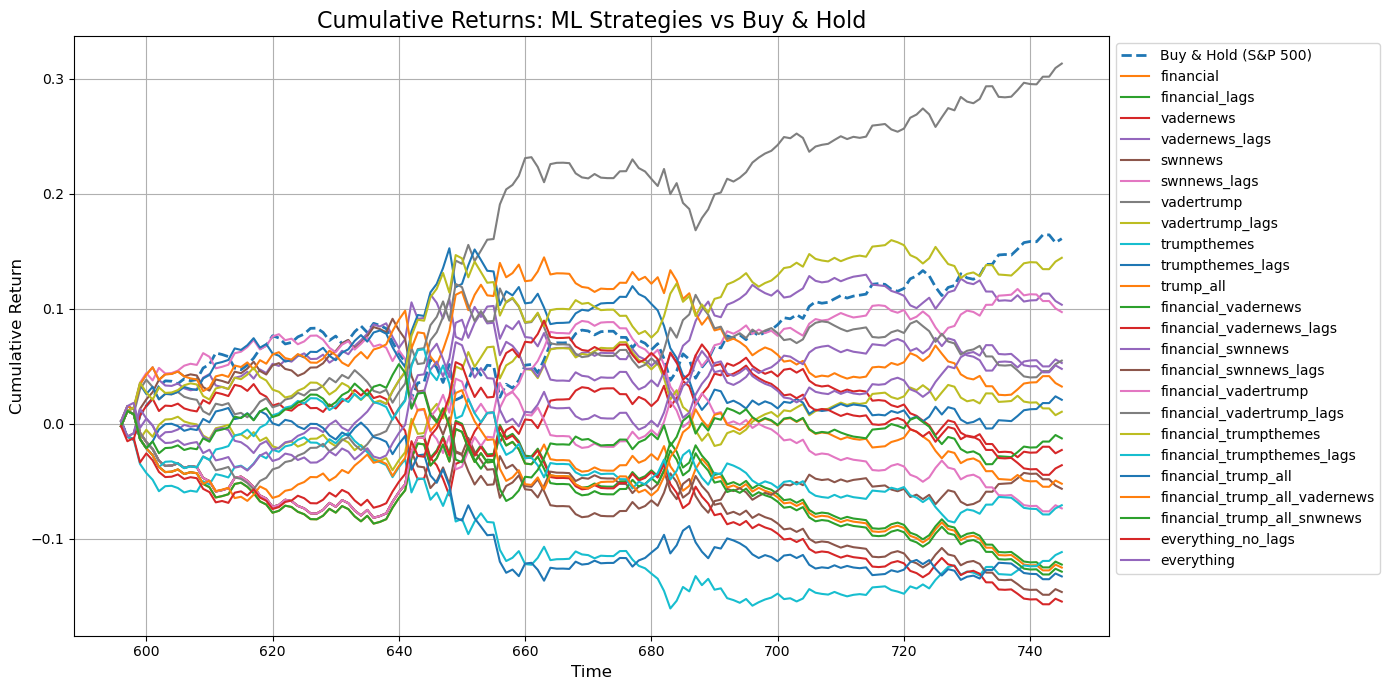

In [294]:
import matplotlib.pyplot as plt
import numpy as np

# Get test returns and dates
test_returns = df_test['returns_tomorrow'].values
test_dates = df_test.index if 'Date' not in df_test.columns else df_test['Date'].values

# Calculate Buy & Hold
buy_hold_cum_returns = np.cumprod(1 + test_returns) - 1

# Set up plot
plt.figure(figsize=(14, 7))

# Plot Buy & Hold
plt.plot(test_dates, buy_hold_cum_returns, label='Buy & Hold (S&P 500)', linewidth=2, linestyle='--')

# Plot strategy returns for each model
for name, model in best_models.items():
    features = feature_sets[name]
    
    X_test = df_test[features].copy()
    X_test.columns = [str(col) for col in X_test.columns]
    X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)

    preds = model.predict(X_test)
    direction = np.where(preds == 1, 1, -1)
    strategy_returns = direction * test_returns
    strategy_cum_returns = np.cumprod(1 + strategy_returns) - 1

    # Optional: Filter for best N models or label top 3 by final PnL
    plt.plot(test_dates, strategy_cum_returns, label=name)

# Final plot tweaks
plt.title("Cumulative Returns: ML Strategies vs Buy & Hold", fontsize=16)
plt.xlabel("Date" if 'Date' in df_test.columns else "Time", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot Creation

In [319]:
# Define selected models
selected_sets = [
    "vadertrump",
    "financial_trumpthemes",
    "vadernews_lags",
    "swnnews_lags",
    "vadertrump_lags",
    "financial_vadernews",
    "everything_no_lags"
]

# Display summaries for only selected models
cv_summary_filtered = cv_results_summary.loc[selected_sets]
test_summary_filtered = test_results_summary[test_results_summary["Feature Set"].isin(selected_sets)]

# Display both tables
display(cv_summary_filtered)
display(test_summary_filtered)

,Best Model,Accuracy,Precision,Recall,F1 Score,AUROC,Strategy PnL
vadertrump,RF (depth=4),0.514831,0.564460,0.609023,0.585895,0.517629,0.162606
financial_trumpthemes,KNN (k=3),0.533898,0.589844,0.567669,0.578544,0.560278,0.257364
vadernews_lags,KNN (k=3),0.548729,0.588040,0.665414,0.624339,0.533670,0.141685
vadertrump_lags,RF (depth=8),0.557203,0.598616,0.650376,0.623423,0.532721,0.541378
financial_vadernews,RF (depth=4),0.527542,0.672000,0.315789,0.429668,0.526863,0.384642
everything_no_lags,RF (depth=12),0.544492,0.604082,0.556391,0.579256,0.520768,0.344699


,Feature Set,Best Model,Accuracy,Precision,Recall,F1 Score,AUROC,Strategy PnL
11,financial_vadernews,RandomForestClassifier,0.400000,0.500000,0.011111,0.021739,0.472407,-0.130294
22,everything_no_lags,RandomForestClassifier,0.446667,0.652174,0.166667,0.265487,0.504630,-0.035198
7,vadertrump_lags,RandomForestClassifier,0.546667,0.644737,0.544444,0.590361,0.539630,0.011918
3,vadernews_lags,KNeighborsClassifier,0.546667,0.622222,0.622222,0.622222,0.566481,0.105905
17,financial_trumpthemes,KNeighborsClassifier,0.546667,0.671875,0.477778,0.558442,0.559537,0.136353
6,vadertrump,RandomForestClassifier,0.606667,0.686747,0.633333,0.658960,0.614444,0.274011


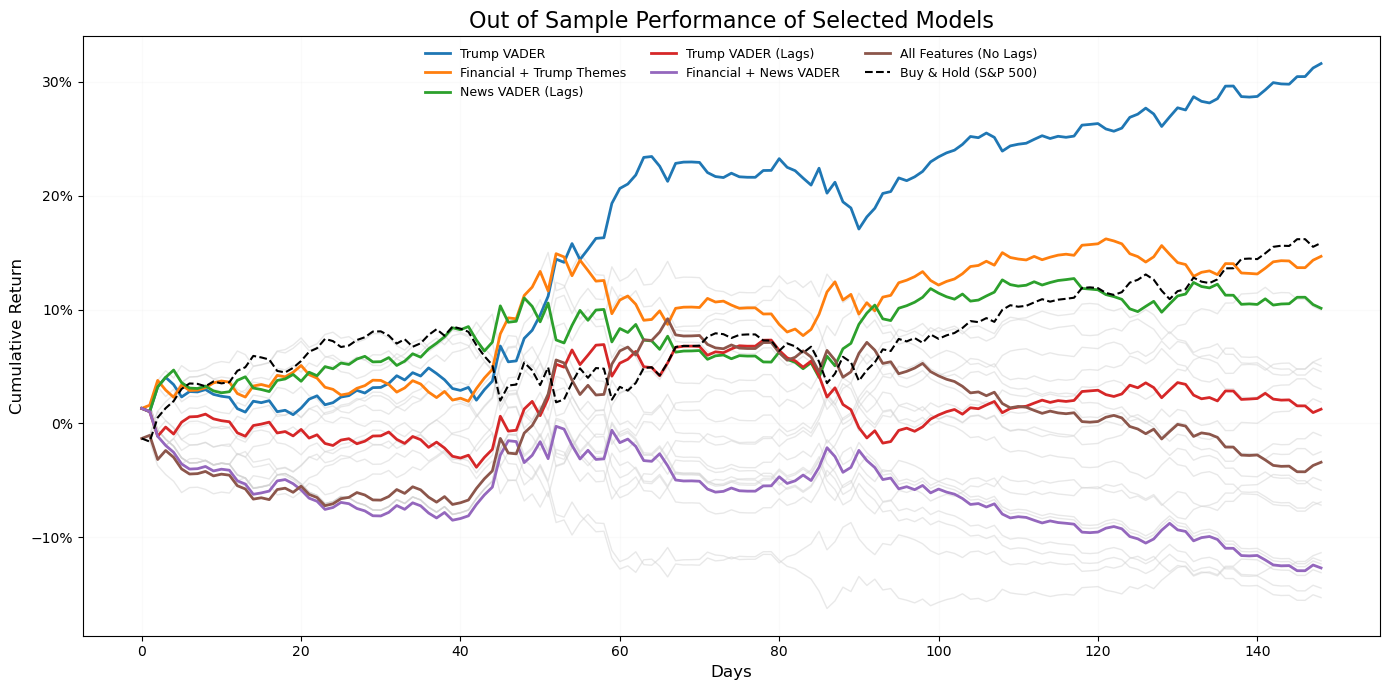

In [475]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# Selected strategies
selected_sets = [
    "vadertrump",
    "financial_trumpthemes",
    "vadernews_lags",
    "vadertrump_lags",
    "financial_vadernews",
    "everything_no_lags"
]

# Custom labels
display_names = {
    "vadertrump": "Trump VADER",
    "financial_trumpthemes": "Financial + Trump Themes",
    "vadernews_lags": "News VADER (Lags)",
    "vadertrump_lags": "Trump VADER (Lags)",
    "financial_vadernews": "Financial + News VADER",
    "everything_no_lags": "All Features (No Lags)",
    "Buy & Hold (S&P 500)": "Buy & Hold (S&P 500)"
}

# Plot
plt.figure(figsize=(14, 7))

# Grey background for all strategies
for name, returns in all_test_strategy_returns.items():
    strategy_cum = np.cumprod(1 + returns[1:]) - 1
    if name not in selected_sets:
        plt.plot(strategy_cum, color='lightgrey', linewidth=1, alpha=0.5)

# Colored lines for selected
for name in selected_sets:
    returns = all_test_strategy_returns[name]
    strategy_cum = np.cumprod(1 + returns[1:]) - 1
    label = display_names.get(name, name)
    plt.plot(strategy_cum, label=label, linewidth=2)

# Buy & Hold benchmark
cum_snp_returns = np.cumprod(1 + df_test["returns_tomorrow"].values[1:]) - 1
plt.plot(cum_snp_returns, label=display_names["Buy & Hold (S&P 500)"], linestyle='--', color='black')

# Title and axis formatting
plt.title("Out of Sample Performance of Selected Models", fontsize=16)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Convert to percentage
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=3, fontsize=9, frameon=False)
plt.grid(alpha=0.05)
plt.tight_layout()
plt.show()

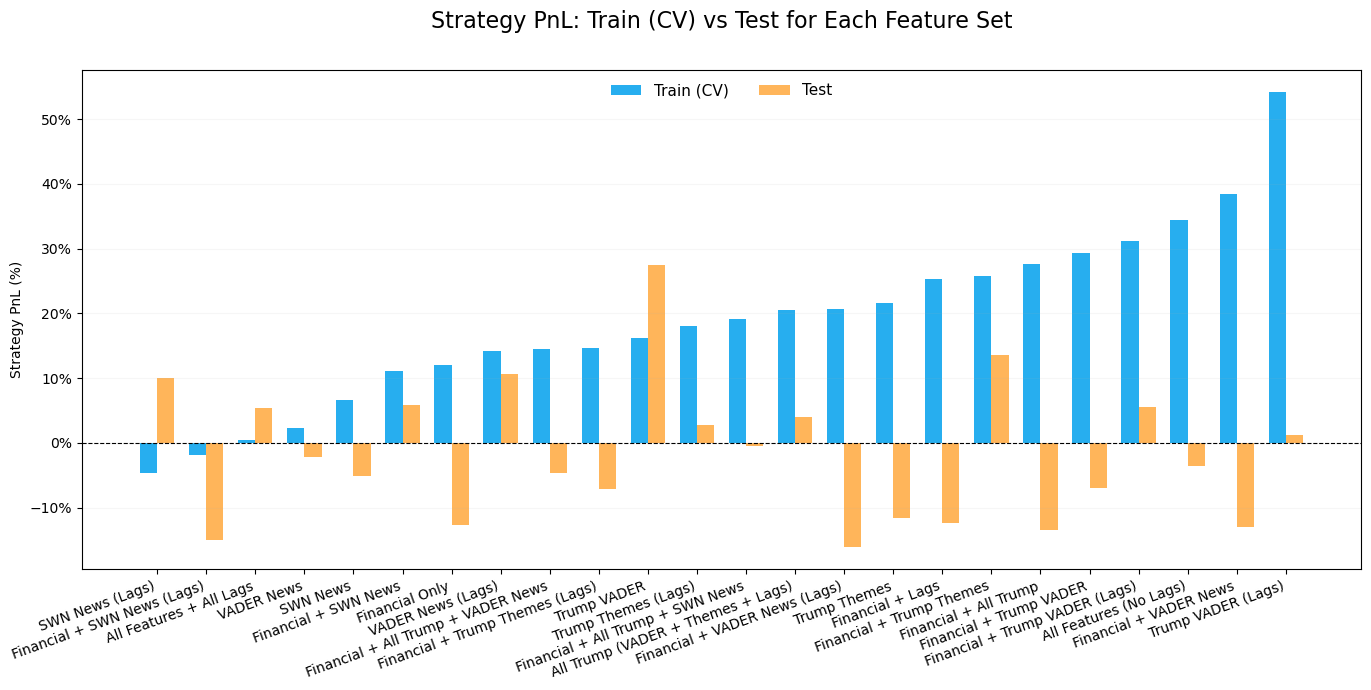

In [369]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import PercentFormatter

# Make a copy and reset index on cv results, then rename
cv_df = cv_results_summary.copy().reset_index()
cv_df = cv_df.rename(columns={'index': 'Feature Set'})

# Do the same for test results just in case
test_df = test_results_summary.copy()
if 'Feature Set' not in test_df.columns:
    test_df = test_df.rename(columns={'index': 'Feature Set'})

# Merge the two summaries on Feature Set
merged_pnl = pd.merge(
    cv_df[['Feature Set', 'Strategy PnL']],
    test_df[['Feature Set', 'Strategy PnL']],
    on='Feature Set',
    suffixes=('_Train', '_Test')
)

# Define prettier names
pretty_names = {
    'financial': 'Financial Only',
    'financial_lags': 'Financial + Lags',

    'vadernews': 'VADER News',
    'vadernews_lags': 'VADER News (Lags)',

    'swnnews': 'SWN News',
    'swnnews_lags': 'SWN News (Lags)',

    'vadertrump': 'Trump VADER',
    'vadertrump_lags': 'Trump VADER (Lags)',

    'trumpthemes': 'Trump Themes',
    'trumpthemes_lags': 'Trump Themes (Lags)',

    'trump_all': 'All Trump (VADER + Themes + Lags)',

    'financial_vadernews': 'Financial + VADER News',
    'financial_vadernews_lags': 'Financial + VADER News (Lags)',

    'financial_swnnews': 'Financial + SWN News',
    'financial_swnnews_lags': 'Financial + SWN News (Lags)',

    'financial_vadertrump': 'Financial + Trump VADER',
    'financial_vadertrump_lags': 'Financial + Trump VADER (Lags)',

    'financial_trumpthemes': 'Financial + Trump Themes',
    'financial_trumpthemes_lags': 'Financial + Trump Themes (Lags)',

    'financial_trump_all': 'Financial + All Trump',
    'financial_trump_all_vadernews': 'Financial + All Trump + VADER News',
    'financial_trump_all_snwnews': 'Financial + All Trump + SWN News',

    'everything_no_lags': 'All Features (No Lags)',
    'everything': 'All Features + All Lags'
}


merged_pnl['Feature Set'] = merged_pnl['Feature Set'].map(pretty_names)

# Plotting
plt.figure(figsize=(14, 7))
x = np.arange(len(merged_pnl))
width = 0.35

plt.bar(x - width/2, merged_pnl['Strategy PnL_Train'], width, label='Train (CV)', color='#27aeef')
plt.bar(x + width/2, merged_pnl['Strategy PnL_Test'], width, label='Test', color='#ffb55a')

plt.xticks(x, merged_pnl['Feature Set'], rotation=20, ha='right')
plt.ylabel("Strategy PnL (%)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.title("Strategy PnL: Train (CV) vs Test for Each Feature Set", fontsize=16, pad=30)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.), ncol=2, fontsize=11, frameon=False)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()
plt.show()

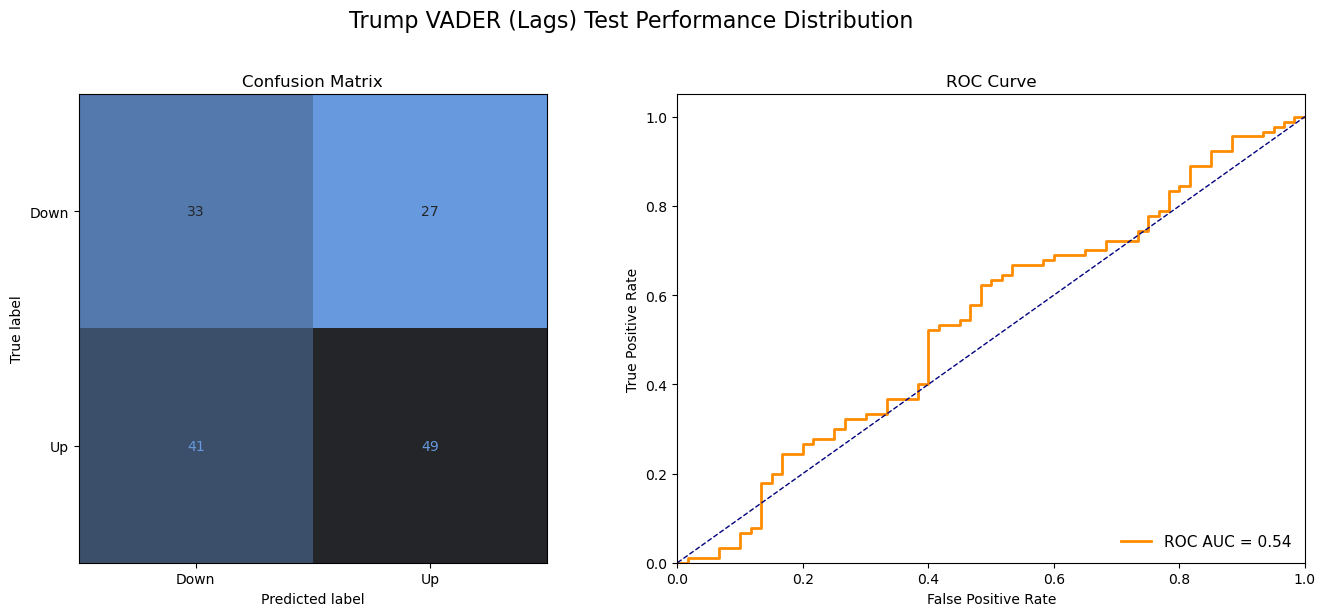

In [469]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Extract test data
model = best_models['vadertrump_lags']
features = feature_sets['vadertrump_lags']

X_test = df_test[features].copy().apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
y_test = df_test['Target'].astype(int)

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Compute metrics
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Define seaborn cmap
custom_cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))


fig.suptitle('Trump VADER (Lags) Test Performance Distribution', fontsize=16, y=1.02)

# Confusion matrix
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
disp_cm.plot(ax=axes[0], cmap=custom_cmap, values_format='d', colorbar=False)
axes[0].set_title('Confusion Matrix')

# ROC AUC
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right', bbox_to_anchor=(1, 0), ncol=2, fontsize=11, frameon=False)

plt.tight_layout()
plt.show()

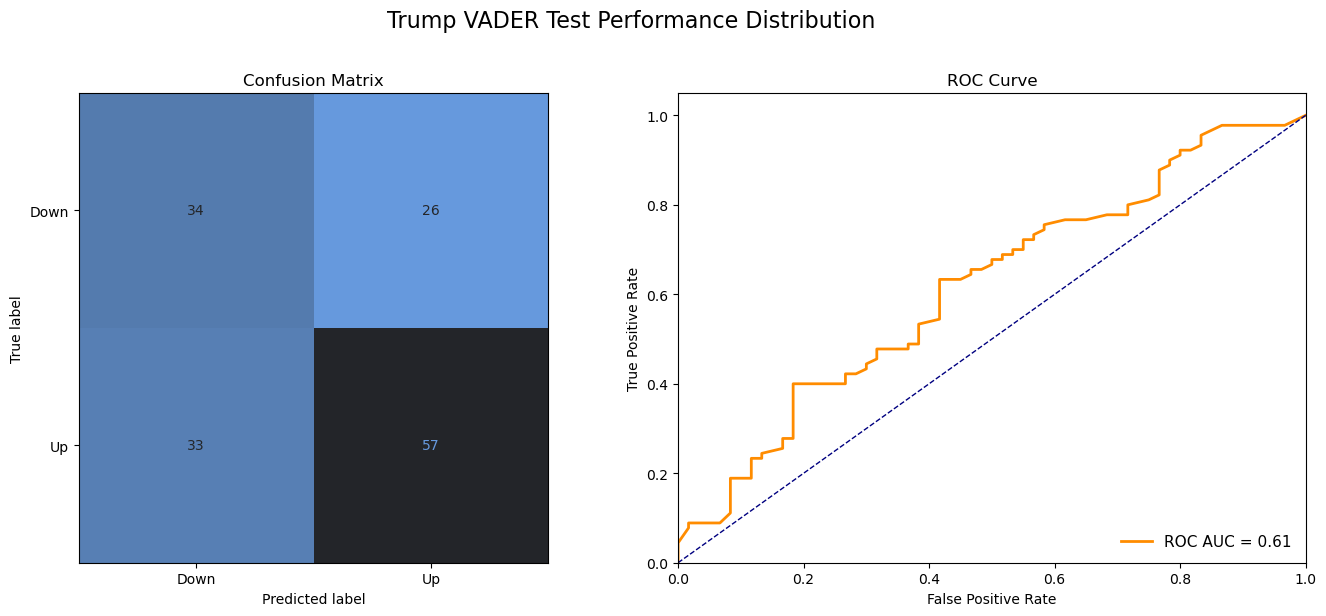

In [471]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Extract test data
model = best_models['vadertrump']
features = feature_sets['vadertrump']

X_test = df_test[features].copy().apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
y_test = df_test['Target'].astype(int)

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Compute metrics
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Define seaborn cmap
custom_cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Add main title
fig.suptitle('Trump VADER Test Performance Distribution', fontsize=16, y=1.02)

# Confusion matrix
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
disp_cm.plot(ax=axes[0], cmap=custom_cmap, values_format='d', colorbar=False)
axes[0].set_title('Confusion Matrix')

# ROC AUC
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right', bbox_to_anchor=(1, 0), ncol=2, fontsize=11, frameon=False)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [485]:
from IPython.display import display, HTML

# Copy and reset index
cv_table = cv_results_summary.copy().reset_index()
cv_table = cv_table.rename(columns={'index': 'Feature Set'})

# Map pretty feature names
cv_table['Feature Set'] = cv_table['Feature Set'].map(pretty_names)

# Convert performance metrics to 3 significant figures (and convert % where relevant)
cv_table['Strategy PnL'] = (cv_table['Strategy PnL'] * 100).apply(lambda x: f"{x:.3g}")
cv_table['AUROC'] = (cv_table['AUROC'] * 100).apply(lambda x: f"{x:.3g}")
for col in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    cv_table[col] = cv_table[col].apply(lambda x: f"{x:.3g}")

# Rename columns
cv_table = cv_table.rename(columns={
    'Best Model': 'Model',
    'AUROC': 'AUROC (%)',
    'Strategy PnL': 'Strategy PnL (%)'
})

# Styling and HTML display
styled_table = cv_table.style.set_table_attributes("style='display:inline'").set_caption(
    "CV Performance Summary for All Feature Sets"
).set_properties(**{
    'text-align': 'center',
}).set_table_styles([
    {"selector": "th", "props": [("text-align", "center")]},
    {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "16px"), ("font-weight", "bold")]}
]).hide(axis="index")

display(HTML(styled_table.to_html()))

Feature Set,Model,Accuracy,Precision,Recall,F1 Score,AUROC (%),Strategy PnL (%)
SWN News (Lags),RF (depth=12),0.504,0.553,0.624,0.587,47.3,-4.59
Financial + SWN News (Lags),RF (depth=4),0.494,0.605,0.293,0.395,51.2,-1.82
All Features + All Lags,RF (depth=12),0.506,0.558,0.594,0.576,48.6,0.41
VADER News,Logistic (C=0.1),0.515,0.57,0.564,0.567,53.5,2.36
SWN News,"XGB (lr=0.1, depth=3)",0.521,0.567,0.635,0.599,49.1,6.69
Financial + SWN News,KNN (k=3),0.511,0.575,0.504,0.537,50.4,11.1
Financial Only,"XGB (lr=0.05, depth=4)",0.498,0.607,0.308,0.409,50.3,12
VADER News (Lags),KNN (k=3),0.549,0.588,0.665,0.624,53.4,14.2
Financial + All Trump + VADER News,KNN (k=5),0.506,0.562,0.564,0.563,51.7,14.6
Financial + Trump Themes (Lags),KNN (k=3),0.525,0.581,0.568,0.574,52.6,14.6


In [489]:
from IPython.display import display, HTML

# Prepare the tables
cv_table = cv_results_summary.copy().reset_index()
test_table = test_results_summary.copy().reset_index()

# Merge CV and Test results
merged = pd.merge(
    cv_table[['index', 'Best Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC', 'Strategy PnL']],
    test_table[['Feature Set', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC', 'Strategy PnL']],
    left_on='index', right_on='Feature Set',
    suffixes=('_CV', '_Test')
)

# Rename feature sets using pretty names
merged['Feature Set'] = merged['index'].map(pretty_names)

# Calculate percentage-point difference in PnL
merged['Δ PnL (p.p.)'] = (merged['Strategy PnL_Test'] - merged['Strategy PnL_CV']) * 100

# Sort by test PnL (descending)
merged = merged.sort_values(by='Strategy PnL_Test', ascending=False)

# Final formatting
final_table = merged[['Feature Set', 'Best Model', 
                      'Accuracy_Test', 'Precision_Test', 'Recall_Test', 'F1 Score_Test', 'AUROC_Test', 
                      'Strategy PnL_Test', 'Δ PnL (p.p.)']]

final_table.columns = ['Feature Set', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score',
                       'AUROC (%)', 'Strategy PnL (%)', 'Δ PnL (p.p.)']

# Format values to 3 significant figures
for col in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    final_table[col] = final_table[col].apply(lambda x: f"{x:.3g}")
final_table['AUROC (%)'] = (final_table['AUROC (%)'] * 100).apply(lambda x: f"{x:.3g}")
final_table['Strategy PnL (%)'] = (final_table['Strategy PnL (%)'] * 100).apply(lambda x: f"{x:.3g}")
final_table['Δ PnL (p.p.)'] = final_table['Δ PnL (p.p.)'].apply(lambda x: f"{x:+.3g}")

# Style the table
styled = final_table.style.set_table_attributes("style='display:inline'").set_caption(
    "Test Performance Summary and Change from CV"
).set_properties(**{'text-align': 'center'}).set_table_styles([
    {"selector": "th", "props": [("text-align", "center")]},
    {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "16px"), ("font-weight", "bold")]}
]).hide(axis="index")

# Display
display(HTML(styled.to_html()))

/var/folders/11/xm61jt5j3bgcdskv3tnccjdh0000gn/T/ipykernel_49862/1724606300.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_table[col] = final_table[col].apply(lambda x: f"{x:.3g}")
/var/folders/11/xm61jt5j3bgcdskv3tnccjdh0000gn/T/ipykernel_49862/1724606300.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_table['AUROC (%)'] = (final_table['AUROC (%)'] * 100).apply(lambda x: f"{x:.3g}")
/var/folders/11/xm61jt5j3bgcdskv3tnccjdh0000gn/T/ipykernel_49862/1724606300.py:36: SettingWithCopyWarn

Feature Set,Model,Accuracy,Precision,Recall,F1 Score,AUROC (%),Strategy PnL (%),Δ PnL (p.p.)
Trump VADER,RF (depth=4),0.607,0.687,0.633,0.659,61.4,27.4,+11.1
Financial + Trump Themes,KNN (k=3),0.547,0.672,0.478,0.558,56,13.6,-12.1
VADER News (Lags),KNN (k=3),0.547,0.622,0.622,0.622,56.6,10.6,-3.58
SWN News (Lags),RF (depth=12),0.573,0.635,0.678,0.656,51,10,+14.6
Financial + SWN News,KNN (k=3),0.54,0.64,0.533,0.582,52.2,5.89,-5.25
Financial + Trump VADER (Lags),KNN (k=5),0.553,0.78,0.356,0.489,60.5,5.5,-25.7
All Features + All Lags,RF (depth=12),0.52,0.737,0.311,0.438,55.1,5.4,+4.99
All Trump (VADER + Themes + Lags),Logistic (C=10),0.5,0.615,0.444,0.516,50.9,3.93,-16.6
Trump Themes (Lags),KNN (k=5),0.527,0.602,0.622,0.612,49.3,2.81,-15.2
Trump VADER (Lags),RF (depth=8),0.547,0.645,0.544,0.59,54,1.19,-52.9
